In [1]:
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor, Lambda
# loading mnist dataset
trainset = datasets.FashionMNIST(
    "data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)
batch_size=512

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)


In [2]:
# FashionMNIST dataset label is 
# 0: T-Shirt
# 1: Trouser
# 2: Pullover
# 3: Dress
# 4: Coat
# 5: Sandal
# 6: Shirt
# 7: Sneaker
# 8: Bag
# 9: Ankle Boot
# fashion_mnist_labels = {
#     0: "T-Shirt",
#     1: "Trouser",
#     2: "Pullover",
#     3: "Dress",
#     4: "Coat",
#     5: "Sandal",
#     6: "Shirt",
#     7: "Sneaker",
#     8: "Bag",
#     9: "Ankle Boot"
# }


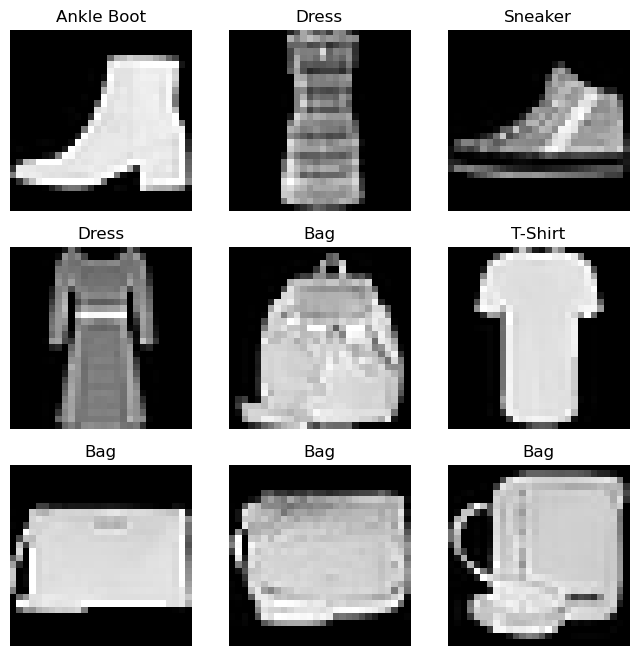

In [6]:
import matplotlib.pyplot as plt

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
map_labels = {
    "T-Shirt": 0,
    "Trouser": 1,
    "Pullover": 2,
    "Dress": 3,
    "Coat": 4,
    "Sandal": 5,
    "Shirt": 6,
    "Sneaker": 7,
    "Bag": 8,
    "Ankle Boot": 9,
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(trainset), size=(1,)).item()
    img, label = trainset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [7]:
from torchcfm.conditional_flow_matching import *
from torchcfm.models.unet import UNetModel


model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

UNetModelWrapper(
  (time_embed): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): SiLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (label_emb): Embedding(10, 128)
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=128, out_features=32, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 32, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0, inplace=False)
          (3): Conv2d(32

In [8]:
print(f"total parameters: {sum(p.numel() for p in model.parameters())}")

total parameters: 1076641


In [9]:
def pad_t_like_x(t, x):
    """Function to reshape the time vector t by the number of dimensions of x.

    Parameters
    ----------
    x : Tensor, shape (bs, *dim)
        represents the source minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    t : Tensor, shape (bs, number of x dimensions)

    Example
    -------
    x: Tensor (bs, C, W, H)
    t: Vector (bs)
    pad_t_like_x(t, x): Tensor (bs, 1, 1, 1)
    """
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))

def sample_location_and_conditional_flow(x0,x1,t=None,return_noise=False,sigma=0.0):
        """
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon


        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) eps: Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], "t has to have batch size dimension"
        eps = torch.randn_like(x0)
        # sample xt \sim N(tx1+(1-t)x0,sigma)
        # 1. mu_t = tx1+(1-t)x0
        t_pad = pad_t_like_x(t, x0)
        mu_t = x1 * t_pad + x0 * (1 - t_pad)
        # 2. sigma_t = sigma
        sigma_t = sigma 
        # 3. xt \sim N(mu_t,sigma_t)
        xt = mu_t + sigma_t * eps
        # 4. ut = x1 - x0
        ut = x1 - x0
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut


In [10]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [11]:
n_epochs = 10
loss_list = []
for epoch in range(n_epochs):
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        print(f"epoch: {epoch}, steps: {i}, loss: {loss.item():.4}", end="\r")
        loss_list.append(loss.item())

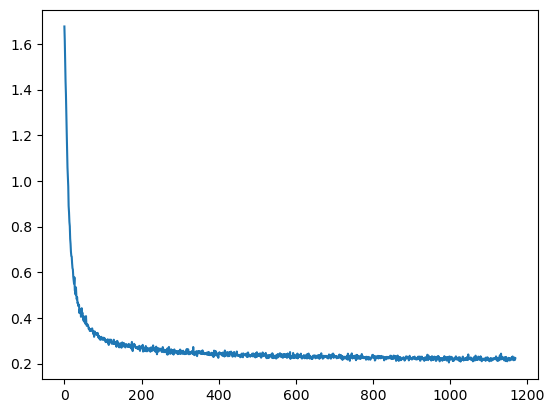

In [13]:
# plot loss
plt.plot(loss_list)
plt.show()


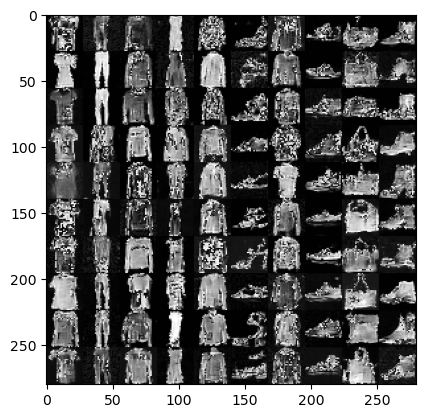

In [15]:
import torchdiffeq
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage


USE_TORCH_DIFFEQ = True
generated_class_list = torch.arange(10, device=device).repeat(10)
with torch.no_grad():
    if USE_TORCH_DIFFEQ:
        traj = torchdiffeq.odeint(
            lambda t, x: model.forward(t, x, generated_class_list),
            torch.randn(100, 1, 28, 28, device=device),
            torch.linspace(0, 1, 2, device=device),
            atol=1e-4,
            rtol=1e-4,
            method="dopri5",
        )
    else:
        traj = node.trajectory(
            torch.randn(100, 1, 28, 28, device=device),
            t_span=torch.linspace(0, 1, 2, device=device),
        )
grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

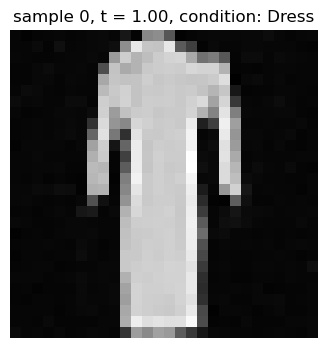

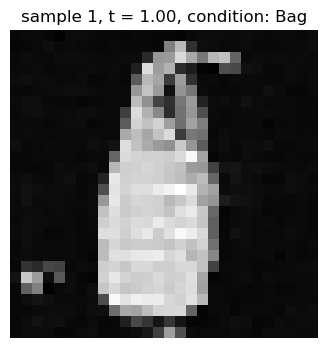

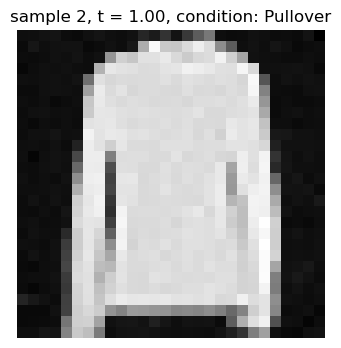

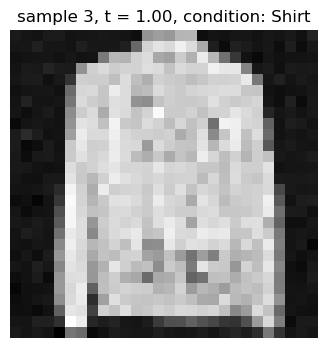

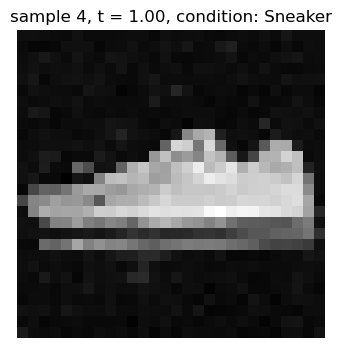

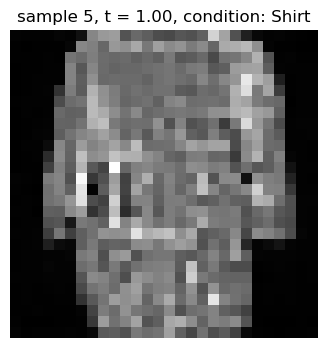

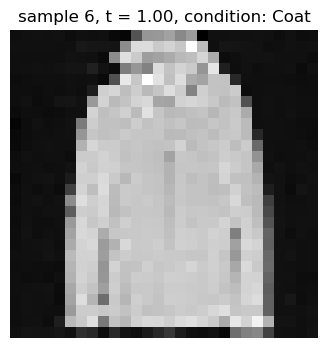

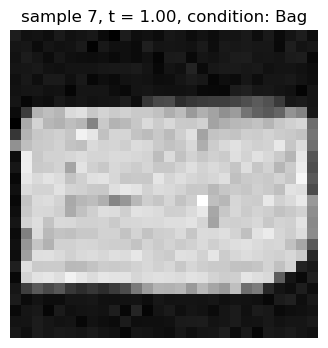

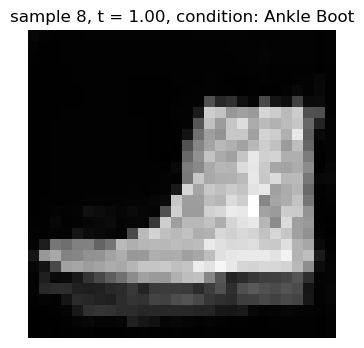

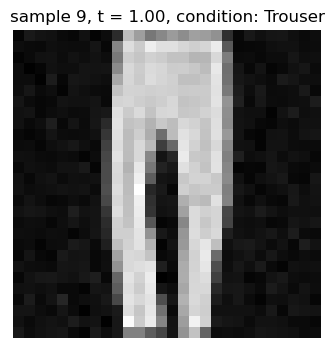

In [14]:
# 采样过程
import random
model.eval()
n_steps = 1000
time_steps = torch.linspace(0, 1.0, n_steps + 1)
dt = time_steps[1] - time_steps[0]

# 初始化

# plt.figure(figsize=(4, 4))
# plt.imshow(x.squeeze().cpu().numpy(), cmap='gray')  # 确保数据在CPU上并使用灰度图
# plt.title(f't = 0')
# plt.axis('off')
# plt.show()

sample_number = 10

with torch.no_grad():  # 在生成过程中不需要计算梯度
    for sample_idx in range(sample_number):
        x = torch.randn(1, 1, 28, 28).to(device)  # 确保初始噪声在正确的设备上
        # condition random from  label_map.keys()
        condition = random.choice(list(map_labels.keys()))
        generated_class = torch.tensor([map_labels[condition]], dtype=torch.long).to(device)  # 指定要生成的类别

        for i in range(n_steps):
            t = time_steps[i].to(device)
            vf = model(t, x, generated_class)
            x = x + vf * dt  # 更新x
            
            if i % 1000 == 0 and i != 0:  # 每10步显示一次生成过程
                plt.figure(figsize=(4, 4))
                plt.imshow(x.squeeze().cpu().numpy(), cmap='gray')  # 确保数据在CPU上并使用灰度图
                plt.title(f'sample {sample_idx}, t = {t.item():.2f}')
                plt.axis('off')
                plt.show()
        # plot
        plt.figure(figsize=(4, 4))
        plt.imshow(x.squeeze().cpu().numpy(), cmap='gray')  # 确保数据在CPU上并使用灰度图
        plt.title(f'sample {sample_idx}, t = {t.item():.2f}, condition: {condition}')
        plt.axis('off')
        plt.show()


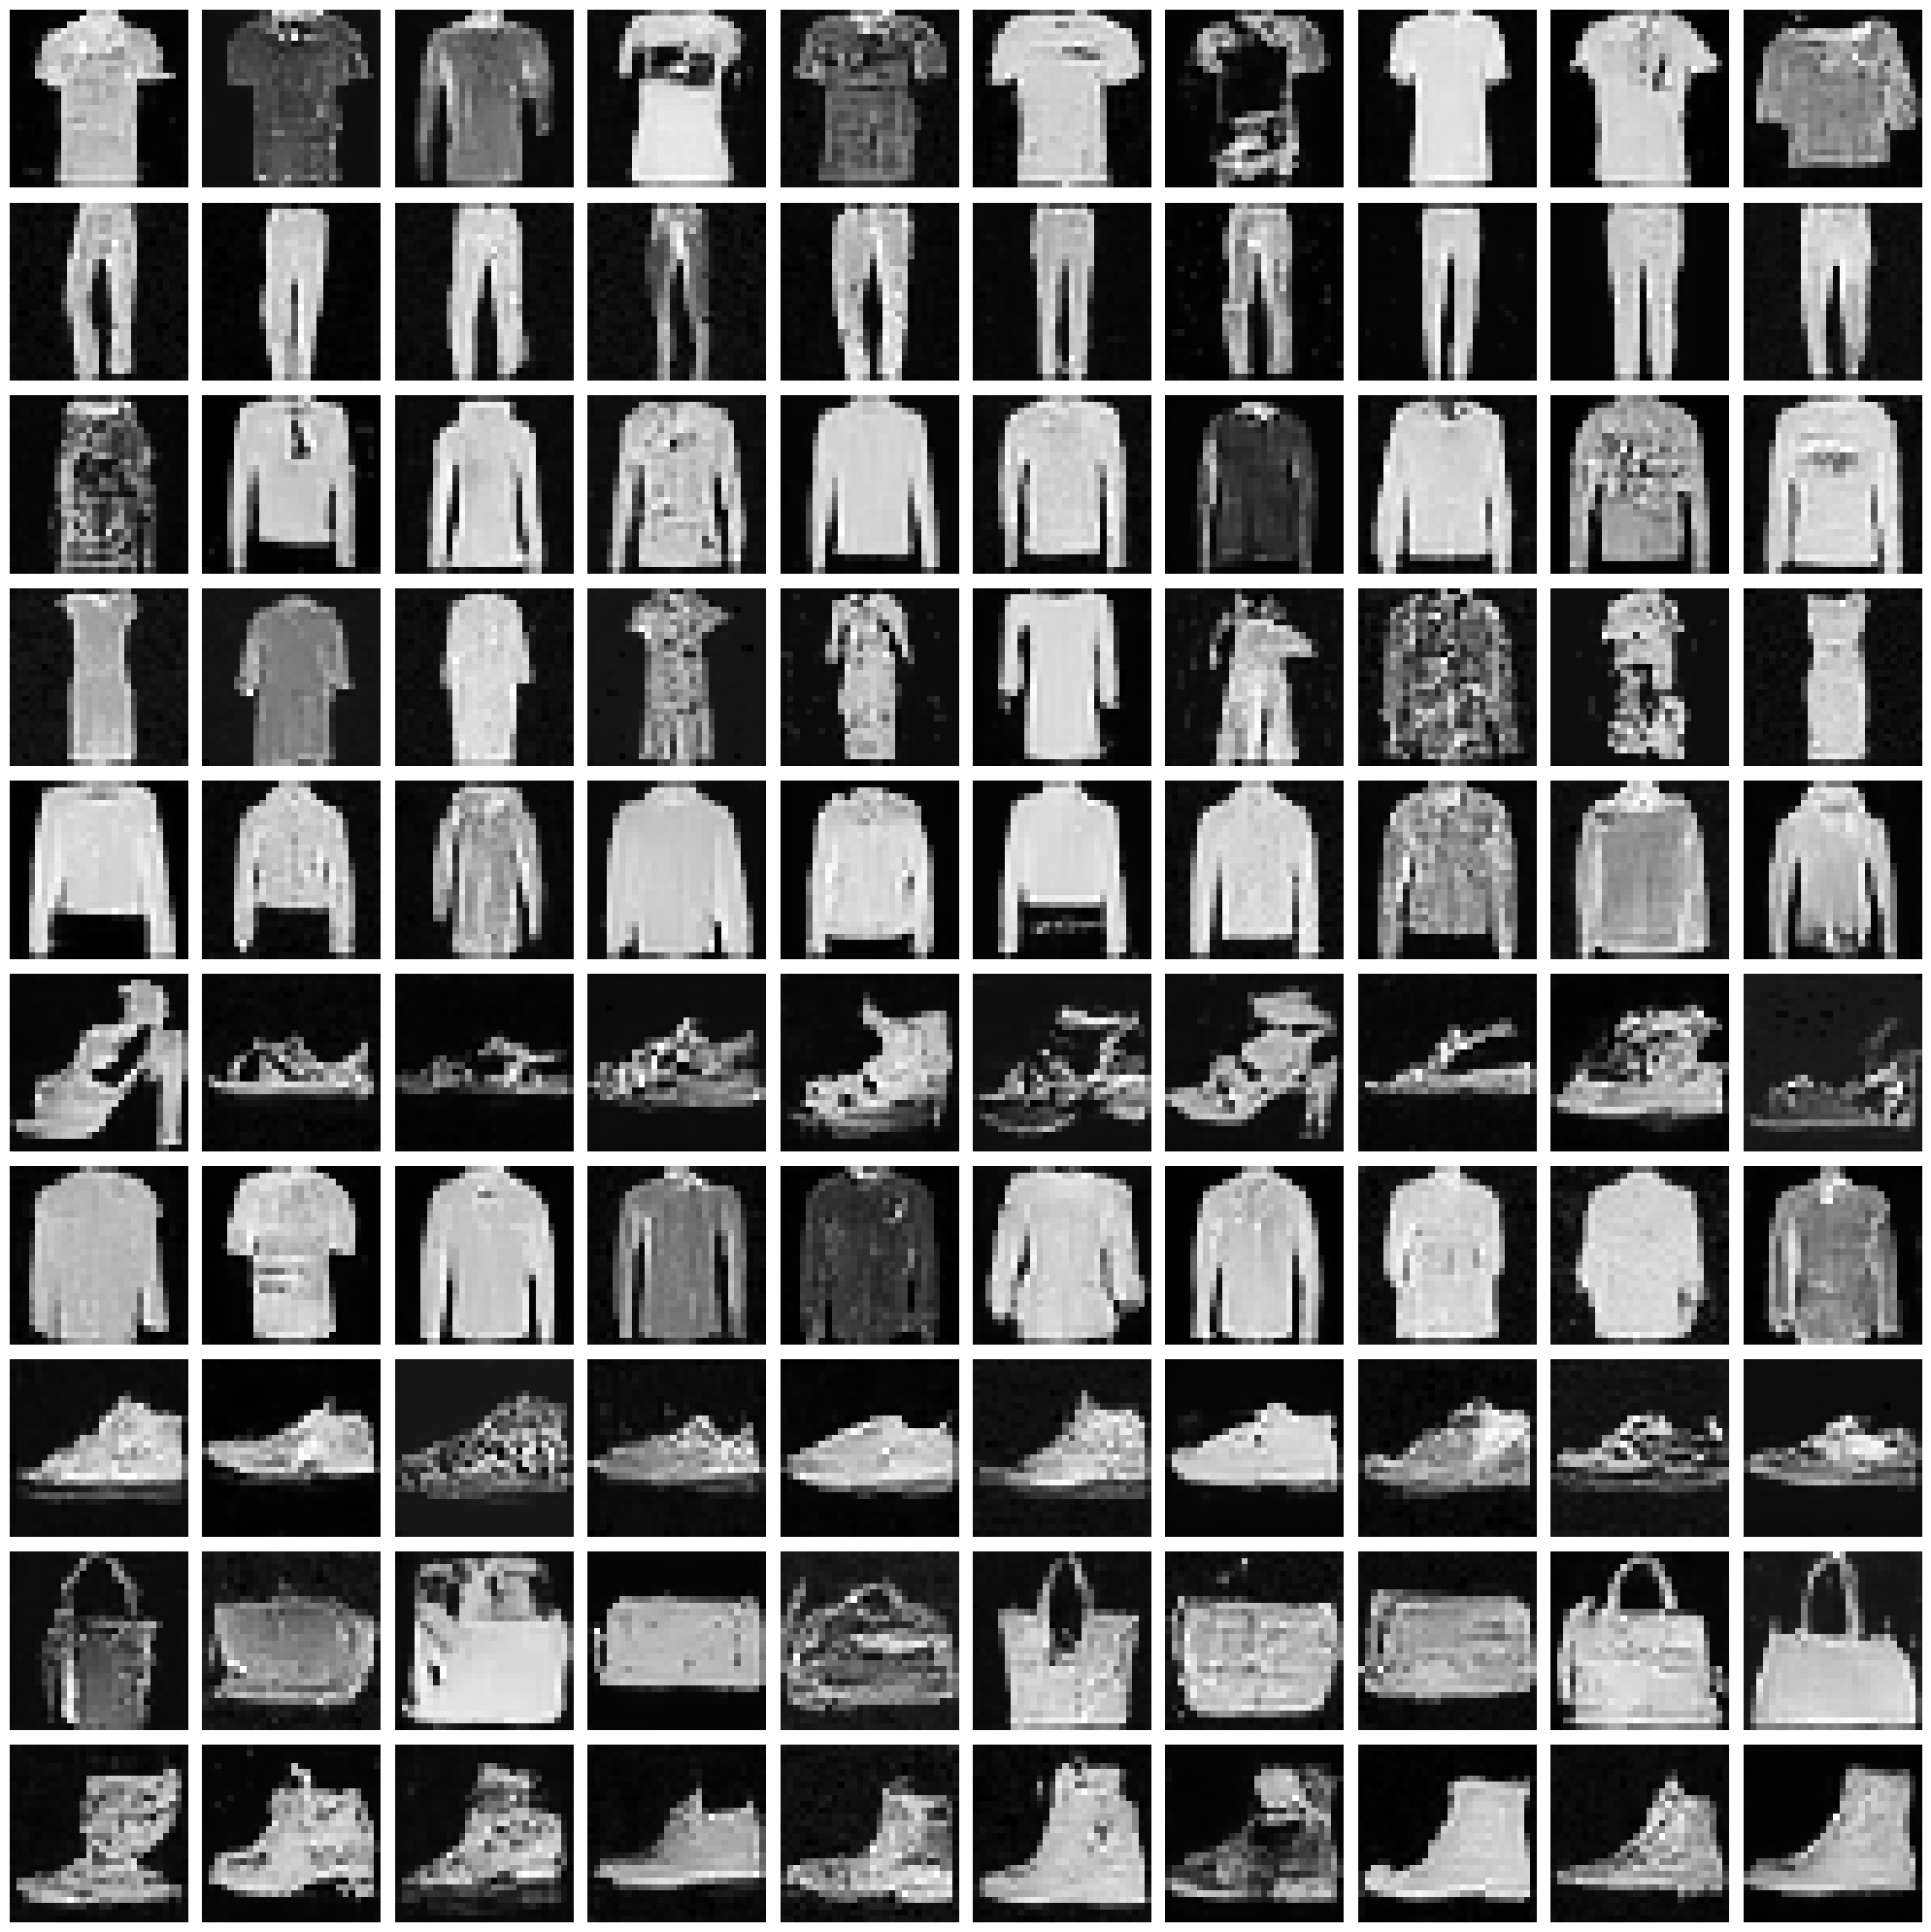

In [15]:
model.eval()
n_steps = 1000
time_steps = torch.linspace(0, 1.0, n_steps + 1)
dt = time_steps[1] - time_steps[0]

# 创建一个10x10的大图
plt.figure(figsize=(20, 20))

# 对每种类别生成10个样本
conditions = list(map_labels.keys())  # 10种衣服类型
n_samples_per_condition = 10

# 存储生成的图像
generated_images = torch.zeros(10, 10, 28, 28)  # (conditions, samples, height, width)

with torch.no_grad():
    # 对每种条件
    for i, condition in enumerate(conditions):
        generated_class = torch.tensor([map_labels[condition]], dtype=torch.long).to(device)
        
        # 每种条件生成10个样本
        for j in range(n_samples_per_condition):
            # 初始化噪声
            x = torch.randn(1, 1, 28, 28).to(device)
            
            # 生成过程
            for step in range(n_steps):
                t = time_steps[step].to(device)
                vf = model(t, x, generated_class)
                x = x + vf * dt
            
            # 保存生成的图像
            generated_images[i, j] = x.squeeze().cpu()

# 绘制网格图
for i in range(10):  # 条件
    for j in range(10):  # 样本
        plt.subplot(10, 10, i*10 + j + 1)
        plt.imshow(generated_images[i, j], cmap='gray')
        if j == 0:  # 只在每行第一个图像显示类别标签
            plt.ylabel(conditions[i], rotation=45, labelpad=25)
        plt.axis('off')

plt.tight_layout()
plt.show()


## OT-transport plan

In [1]:
def guided_sample_location_and_conditional_flow(
    self, x0, x1, y0=None, y1=None, t=None, return_noise=False
):
    r"""
    Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
    and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1]
    with respect to the minibatch OT plan $\Pi$.

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    y0 : Tensor, shape (bs) (default: None)
        represents the source label minibatch
    y1 : Tensor, shape (bs) (default: None)
        represents the target label minibatch
    (optionally) t : Tensor, shape (bs)
        represents the time levels
        if None, drawn from uniform [0,1]
    return_noise : bool
        return the noise sample epsilon

    Returns
    -------
    t : FloatTensor, shape (bs)
    xt : Tensor, shape (bs, *dim)
        represents the samples drawn from probability path pt
    ut : conditional vector field ut(x1|x0) = x1 - x0
    (optionally) epsilon : Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

    References
    ----------
    [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
    """
    x0, x1, y0, y1 = sample_plan_with_labels(x0, x1, y0, y1)
    if return_noise:
        t, xt, ut, eps = sample_location_and_conditional_flow(x0, x1, t, return_noise)
        return t, xt, ut, y0, y1, eps
    else:
        t, xt, ut = sample_location_and_conditional_flow(x0, x1, t, return_noise)
        return t, xt, ut, y0, y1

In [2]:
def sample_map(self, pi, batch_size, replace=True):
    r"""Draw source and target samples from pi  $(x,z) \sim \pi$

    Parameters
    ----------
    pi : numpy array, shape (bs, bs)
        represents the source minibatch
    batch_size : int
        represents the OT plan between minibatches
    replace : bool
        represents sampling or without replacement from the OT plan

    Returns
    -------
    (i_s, i_j) : tuple of numpy arrays, shape (bs, bs)
        represents the indices of source and target data samples from $\pi$
    """
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(
        pi.shape[0] * pi.shape[1], p=p, size=batch_size, replace=replace
    )
    return np.divmod(choices, pi.shape[1])

In [3]:
def get_map(self, x0, x1):
    """Compute the OT plan (wrt squared Euclidean cost) between a source and a target
    minibatch.

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the source minibatch

    Returns
    -------
    p : numpy array, shape (bs, bs)
        represents the OT plan between minibatches
    """
    a, b = pot.unif(x0.shape[0]), pot.unif(x1.shape[0])
    if x0.dim() > 2:
        x0 = x0.reshape(x0.shape[0], -1)
    if x1.dim() > 2:
        x1 = x1.reshape(x1.shape[0], -1)
    M = torch.cdist(x0, x1) ** 2
    if self.normalize_cost:
        M = M / M.max()  # should not be normalized when using minibatches
    p = self.ot_fn(a, b, M.detach().cpu().numpy())
    if not np.all(np.isfinite(p)):
        print("ERROR: p is not finite")
        print(p)
        print("Cost mean, max", M.mean(), M.max())
        print(x0, x1)
    if np.abs(p.sum()) < 1e-8:
        if self.warn:
            warnings.warn("Numerical errors in OT plan, reverting to uniform plan.")
        p = np.ones_like(p) / p.size
    return p

In [15]:
def sample_plan_with_labels(self, x0, x1, y0=None, y1=None, replace=True):
    r"""Compute the OT plan $\pi$ (wrt squared Euclidean cost) between a source and a target
    minibatch and draw source and target labeled samples from pi $(x,z) \sim \pi$

    Parameters
    ----------
    x0 : Tensor, shape (bs, *dim)
        represents the source minibatch
    x1 : Tensor, shape (bs, *dim)
        represents the target minibatch
    y0 : Tensor, shape (bs)
        represents the source label minibatch
    y1 : Tensor, shape (bs)
        represents the target label minibatch
    replace : bool
        represents sampling or without replacement from the OT plan

    Returns
    -------
    x0[i] : Tensor, shape (bs, *dim)
        represents the source minibatch drawn from $\pi$
    x1[j] : Tensor, shape (bs, *dim)
        represents the target minibatch drawn from $\pi$
    y0[i] : Tensor, shape (bs, *dim)
        represents the source label minibatch drawn from $\pi$
    y1[j] : Tensor, shape (bs, *dim)
        represents the target label minibatch drawn from $\pi$
    """
    pi = get_map(x0, x1)
    i, j = sample_map(pi, x0.shape[0], replace=replace)
    return (
        x0[i],
        x1[j],
        y0[i] if y0 is not None else None,
        y1[j] if y1 is not None else None,
    )

## SFM 

给FM加入随机性